# Lab 04 12012727 Duolei Wang

## Preprocessing and libs importing

In [1]:
from sklearn.linear_model import *
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
load_housing = fetch_california_housing()
X = load_housing.data
Y = load_housing.target

In [3]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8)

## Cross-validation

采用交叉检验，来判断多项式回归系列的模型效果

In [43]:
model = Pipeline(
    [('poly', PolynomialFeatures()), 
     ('scala', StandardScaler()), 
     ('linear', LinearRegression())]
)

params = {'poly__degree': [1, 2, 3, 4]}

grid_search = GridSearchCV(model, param_grid=params, cv=5)

grid_search.fit(x_train, y_train)
grid_search.best_score_, grid_search.best_params_, grid_search.score(x_test, y_test)

(0.6002392644990208, {'poly__degree': 1}, 0.611347171786541)

结果发现，1 次多项式（线性回归）具有最好的交叉检验效果.

0.6113471717865497


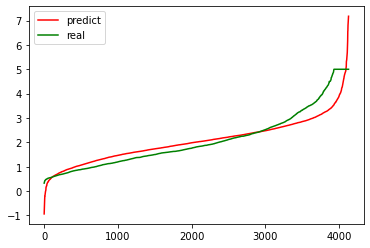

In [5]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred = linear_model.predict(x_test)

print(r2_score(y_test, y_pred))


plt.plot(range(len(y_pred)), sorted(y_pred), c='red')
plt.plot(range(len(y_test)), sorted(y_test), c='green')
plt.legend(["predict", "real"])
plt.show()

## R^2 Score

### 多项式回归（含线性回归）

如果采用 R^2 作为指标，考虑 1-5 次多项式回归，有以下结果：

In [68]:
def r2_Score_Poly_Linear(deg:int, X_train, Y_train, X_test, Y_test):
    poly = PolynomialFeatures(deg)
    
    X_train_new = poly.fit_transform(X_train)
    X_test_new = poly.fit_transform(X_test)
    
    linear = LinearRegression()
    linear.fit(X_train_new, y_train)
    
    y_pred1 = linear.predict(X_train_new)
    y_pred2 = linear.predict(X_test_new)
    
    
    return (r2_score(Y_test, y_pred2), r2_score(Y_train, y_pred1))

In [69]:
lst_poly_r2scores = []

for i in range(1, 6):
    lst_poly_r2scores.append(r2_Score_Poly_Linear(i, x_train, y_train, x_test, y_test))


print("R2 Score:", lst_poly_r2scores)

R2 Score: [(0.6113471717865497, 0.6048192101873069), (-0.3336837476527319, 0.6805742629432449), (-36784.4461157416, 0.7382073974695745), (-2129025266.9530916, 0.7577282666180253), (-248491625411.18588, 0.7279233222076302)]


```
R2 Score [predict, in dataset]: 
[(0.6113471717865497, 0.6048192101873069), 
(-0.3336837476527319, 0.6805742629432449), 
(-36784.4461157416, 0.7382073974695745), 
(-2129025266.9530916, 0.7577282666180253), 
(-248491625411.18588, 0.7279233222076302)]
```

上述
发现效果对于预测数据不是很好，多项式回归超过两次之后几乎不具备预测功能.
对于数据集内部的样本，具有较强的 r2 score, 因此为了兼顾预测功能，线性回归里建议选取线性回归.

### Ridge 回归

猜测数据集会不会是因为 X 的列向量之间的相关性较强，造成一些问题，尝试使用 Ridge 回归

In [7]:
import seaborn as sns
import pandas as pd

<AxesSubplot:>

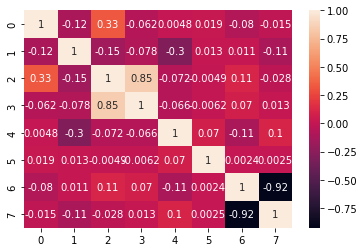

In [8]:
corr = pd.DataFrame(X).corr()
sns.heatmap(corr, annot=True)

如上图发现经纬度是高度相关的

In [9]:
from sklearn.linear_model import Ridge

In [10]:
# 此部分代码运行较慢，建议谨慎使用
model2 = Pipeline(
    [('poly', PolynomialFeatures()), ('scala', StandardScaler()), ('ridge', Ridge())]
)

params2 = {'poly__degree':[1,2,3,4],
           'ridge__alpha':list(x / 10 for x in range(0, 101)),
           'ridge__max_iter':[5,10,100]}

grid_search_2 = GridSearchCV(model2, params2)
grid_search_2.fit(x_train, y_train)
grid_search_2.best_estimator_, grid_search_2.best_params_

迭代测试出结果为：

(Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                 ('scala', StandardScaler()),
                 ('ridge', Ridge(alpha=10.0, max_iter=5))]),
 {'poly__degree': 1, 'ridge__alpha': 10.0, 'ridge__max_iter': 5})

这里测试一下最优参数下的 Ridge 回归的 R^2 Score

In [11]:
model_poly_ridge = Pipeline(
    [('poly', PolynomialFeatures(1)), ('scala', StandardScaler()), ('ridge', Ridge())]
)

model_poly_ridge.fit(x_train, y_train)

y_pred_ridge = model_poly_ridge.predict(x_test)

print(r2_score(y_test, y_pred_ridge))

0.6113404084941937


0.6129593090870646

In [12]:
def r2_Score_Poly_Ridge(degree:int, X, Y):
    poly = PolynomialFeatures(degree)
    X = poly.fit_transform(X)
    
    lm = Ridge()
    lm.fit(X, Y)
    
    y_pred = lm.predict(X)
    
    return r2_score(Y, y_pred)

In [14]:
lst_ridge_r2_scores = []

for i in range(1, 6):
    lst_ridge_r2_scores.append(r2_Score_Poly_Ridge(i, X, Y))


print("R2 Score:", lst_poly_r2scores)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.34124e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.47605e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


R2 Score: [0.606232685199805, 0.6832976293317481, 0.737190943634215, 0.7451024403025747, 0.7258333704225715]


对于原来的数据集内的数据而言：
R2 Score: [0.606232685199805, 0.6832976293317481, 0.737190943634215, 0.7451024403025747, 0.7258333704225715]

### 小结

可以看到，多项式+线性回归（或者 Ridge 回归）时，都是在 4 次多项式具有给定数据最好的 R^2 检验效果，这里猜测是因为数据的 target 绘制出来，具有大概三个波动，于是用四次多项式拟合会造成相对更好的结果.

但是考虑到要具有一定的预测功能，因此采用 1, 2 次多项式，这里根据 r2 得分选择 1 次多项式回归.

## Final model Choosing

由上述结果可以看出来，可以使用多项式特征变换后的线性回归.
以交叉检验的稳定性为主要指标的话，则选取 deg=1，以 R^2 为指标的话，则选取 deg=4.
这里采取 R^2 指标，poly deg=4.

In [70]:
model_final = Pipeline(
    [('poly', PolynomialFeatures(1)), ('scala', StandardScaler()), ('linear', LinearRegression())]
)

model_final.fit(x_train, y_train)
y_pred_final = model_final.predict(x_test)

print("R2 score:", r2_score(y_test, y_pred_final))

0.611347171786541